In [41]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)


In [42]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [43]:
y.shape

(70000,)

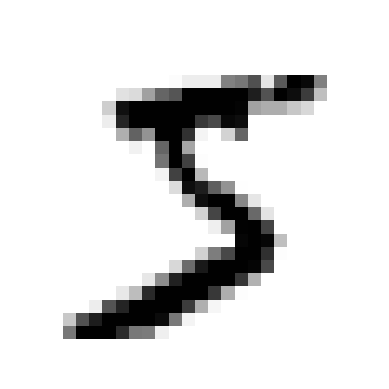

In [44]:
import matplotlib.pyplot as plt

def plot_image(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
some_digit = X[0]
plot_image(some_digit)

In [45]:
y[0]

'5'

In [46]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [47]:
y_train_5= (y_train == '5')
y_test_5 = (y_test == '5')

In [48]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [49]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [50]:
from sklearn.dummy import DummyClassifier
dummy_clf= DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))


False


In [51]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

extra code for custom cross validation


In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

def get_my_scores(clf, X, y):
    my_scores = []
    for train_index, test_index in skfolds.split(X, y):
        clone_clf = clone(clf)
        X_train_folds = X[train_index]
        y_train_folds = y[train_index]
        X_test_fold = X[test_index]
        y_test_fold = y[test_index]

        clone_clf.fit(X_train_folds, y_train_folds)

        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        my_scores.append(n_correct / len(y_pred))
    return my_scores

get_my_scores(sgd_clf, X_train, y_train_5)

[np.float64(0.9669), np.float64(0.91625), np.float64(0.96785)]

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3 )
cf = confusion_matrix(y_train_5, y_train_pred)
cf

array([[53892,   687],
       [ 1891,  3530]])

In [54]:
from sklearn.metrics import precision_score, recall_score



In [55]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [56]:

recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [57]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [58]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [59]:
threshold = 2500
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

so how do we figure out which threshold to use? well, look at the codes below. 

In [60]:
y_scores = cross_val_predict( sgd_clf, X_train, y_train_5, cv=3 , method="decision_function" )


In [61]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)                                                                                             

In [62]:
from matplotlib import pyplot as plt
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='precisions', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label= 'recalls', linewidth=2)
    plt.vlines(threshold, 0, 1, "b", 'dotted', label='threshold')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold')
    plt.grid()
    plt.show()

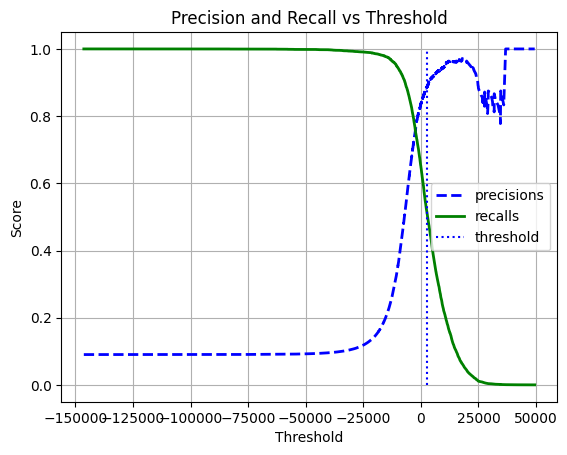

In [63]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

lets see another graph to  make our decision more educated!

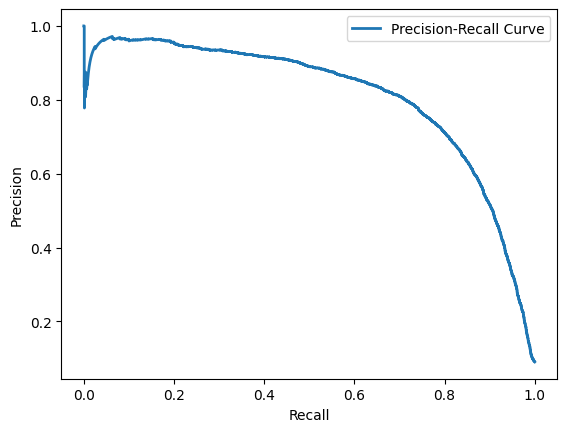

In [64]:
plt.plot(recalls, precisions, label='Precision-Recall Curve', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')

In [65]:
# so how do we figure out which threshold to use? well, look at the codes below.
import numpy as np
idx_for_90_precision = np.argmax(precisions >= 0.90)
threshold = thresholds [idx_for_90_precision]
threshold

np.float64(3370.019499143956)

In [66]:
# so how do we figure out which threshold to use? well, look at the codes below. contd..
y_train_pred_90 = (y_scores >= threshold)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [67]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [68]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)



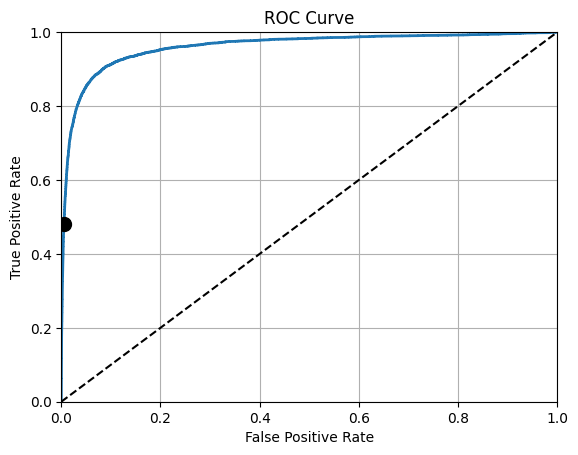

In [72]:
idx_for_threshold_at_90 = (thresholds <= threshold).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label = 'ROC Curve')
plt.plot(fpr_90, tpr_90, 'ko', markersize=10, label ='threshold at 90% ptrcision')
plt.plot([0,1], [0,1], 'k--', label= 'Random Classifiers ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.axis([0,1,0,1])
plt.grid()

In [73]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [75]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)

In [77]:
clf_proba = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = 'predict_proba')


In [79]:
clf_proba[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

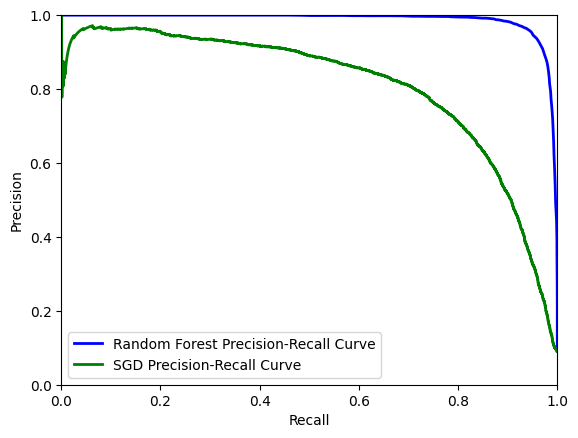

In [81]:
forest_y_scores = clf_proba[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, forest_y_scores)
plt.plot(recalls_forest, precisions_forest,'-b', label='Random Forest Precision-Recall Curve', linewidth=2)
plt.plot(recalls, precisions, '-g', label='SGD Precision-Recall Curve', linewidth=2)
plt.xlabel('Recall')
plt.axis([0, 1, 0, 1])
plt.ylabel('Precision')
plt.legend(loc='best')

In [83]:
y_train_pred_forest = (forest_y_scores >= 0.5)
roc_auc_score(y_train_5, y_train_pred_forest)

0.9358174809192218

Text(0.5, 1.0, 'ROC Curve')

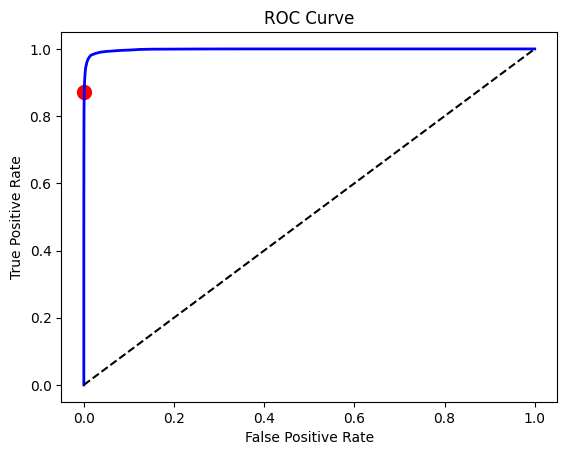

In [85]:
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_train_5, clf_proba[:, 1])
idx_for_threshold_at_90 = (forest_thresholds <= 0.5).argmax()
fpr_90_forest, tpr_90_forest = forest_fpr[idx_for_threshold_at_90], forest_tpr[idx_for_threshold_at_90]
plt.plot(fpr_90_forest, tpr_90_forest, 'ro', label='Random Forest ROC Curve at 90% threshold', markersize=10)
plt.plot(forest_fpr, forest_tpr, '-b', label='Random Forest ROC Curve', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random Classifiers ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')